# Euler's constant approximation by Monte Carlo method

Léo Leroy, Siméon Tsang and Maël Trémouille

## Motivations:

Our goal is to approximate Euler's constant using different Monte Carlo methods and compare their efficiency. This constant is defined as:

$\gamma = \lim_{n \to \infty} \left\{ \sum_{k=1}^{n} \frac{1}{k} - \log(n) \right\} = \sum_{k=1}^{\infty} [\frac{1}{k} - \log \left( 1 + \frac{1}{k} \right)]$

## Requirements 

In [1]:
import numpy as np
import time
import math
import matplotlib.pyplot as plt
from scipy.stats import qmc, poisson, geom  # For quasi-Monte Carlo and some distributions

# Euler's constant true value (for comparison)
true_gamma = np.euler_gamma

np.random.seed(42)

## Question 1

Show that you can use importance sampling to derive unbiased estimates of γ. Hint: as a proposal, you may use for instance the distribution of $X = \lceil \frac{c}{ U^\alpha} \rceil, U \sim U[0, 1]$, for well-chosen constants $c$ and $α$. (Explain your choice.)



### Mathematical derivations

We seek to calculate the Euler's constant $\gamma$. We have $\gamma = \mathbb{E}[\phi(X)]$ where $\phi$ is the constant function equal to $\gamma$ and $p$ is the density of $X$ defined by:
$$
p(k) = \frac{1}{\gamma} \left( \frac{1}{k} - \ln\left(1 + \frac{1}{k}\right) + \frac{1 - \ln(2)}{k(k-1)} \right).
$$

Using importance sampling, we have:
$$
\gamma = \mathbb{E}_q\left[\frac{\varphi(X) p(X)}{q(X)}\right],
\text{ where } q \text{ is the new density of } X, \text{ defined by }
q(k) = \frac{1}{k(k-1)}.
$$
$$
\text{The law } q \text{ is much easier to simulate; indeed,}
$$
$$
\text{the variable }
Y = \lceil \frac{1}{U} \rceil \text{ where } U \text{ follows the uniform distribution on } [0,1]
\text{ follows this law, as demonstrated below.}
$$

The hint suggests using the distribution of $X = \lceil \frac{c}{U^\alpha} \rceil$ where $U \sim U[0, 1]$, and $c$ and $\alpha$ are constants to be chosen. The term $\frac{1}{k} - \log(1+\frac{1}{k})$ is such that for large $k$ we have $\frac{1}{k} - \log(1+\frac{1}{k}) \approx -\frac{1}{2k^2}$. The proposal distribution should have a similar tail behavior. We notice that by fixing $\alpha = 1$, we obtain the following probability mass function:

$$
q(k) = P(X = k) = P\left( \lceil \frac{c}{U} \rceil = k \right) = P\left( \frac{c}{k} \leq U < \frac{c}{k-1} \right), \text{ for } k \geq 2.
$$

Since $U$ follows a uniform distribution, we can simplify: for $k \geq 2$, $q(k) = \frac{c}{k-1} - \frac{c}{k} = \frac{c}{k(k-1)}$, which yields a similar tail behavior as $p$.

To ensure that $q$ is a probability distribution, we must have: $\sum_{k=2}^{\infty} \frac{c}{k-1} - \frac{c}{k} = 1$ which holds if and only if $c = 1$.

Finally, we obtain $X = \lceil \frac{1}{U} \rceil$.



### Graphical view of the function suggested in the indication

We initially set the parameters to 1 for simplicity. Next, we will plot the function for various pairs of parameters to analyze its behavior:

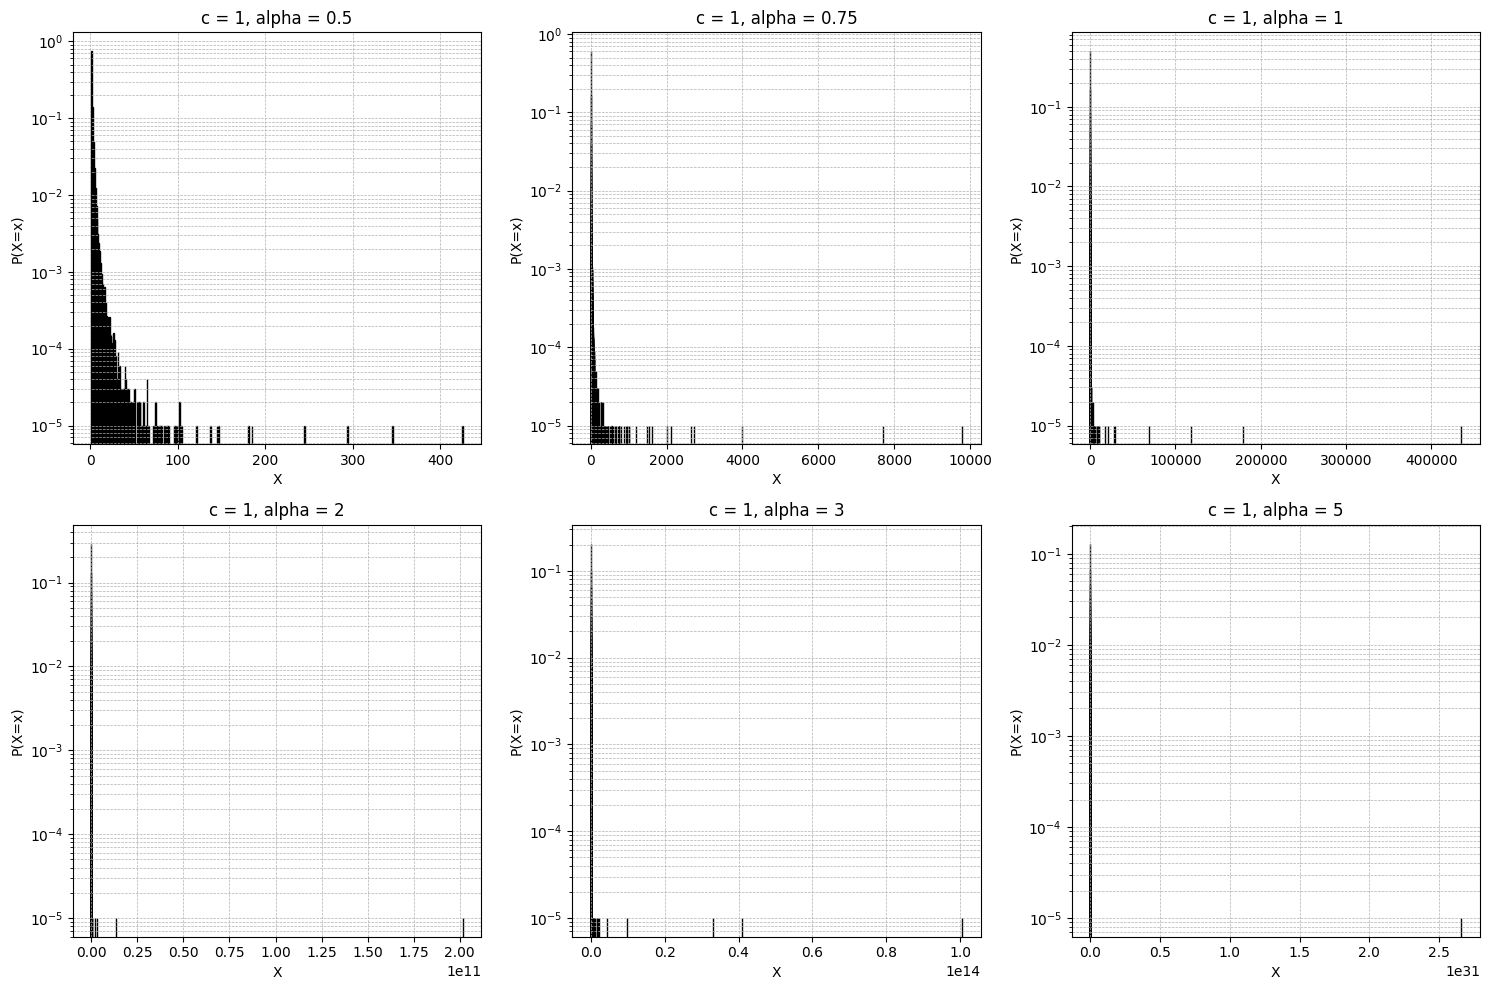

In [2]:
def simulate_X(c, alpha, n=100000):
    U = np.random.uniform(0, 1, n)
    X = np.ceil(c / (U ** alpha))
    return X

# Couples (c, alpha) à tester
params = [(1, .5), (1, .75), (1, 1), (1, 2), (1, 3), (1, 5)]
n_samples = 100000

plt.figure(figsize=(15, 10))

for i, (c, alpha) in enumerate(params, 1):
    X = simulate_X(c, alpha, n=n_samples)
    values, counts = np.unique(X, return_counts=True)
    probs = counts / n_samples

    plt.subplot(2, 3, i)
    plt.bar(values, probs, width=1.0, edgecolor='black')
    plt.title(f"c = {c}, alpha = {alpha}")
    plt.xlabel("X")
    plt.ylabel("P(X=x)")
    plt.yscale('log')  # log-scale pour voir les queues
    plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

Note on Density Validity: here, we do not verify whether the function strictly qualifies as a proper density. Instead, we proceed by visualizing it across different parameter values to explore the shapes of the resulting distributions.

Let's now take a look at:

$$
a_k = \frac{1}{k} - \ln\left(1 + \frac{1}{k}\right).
$$


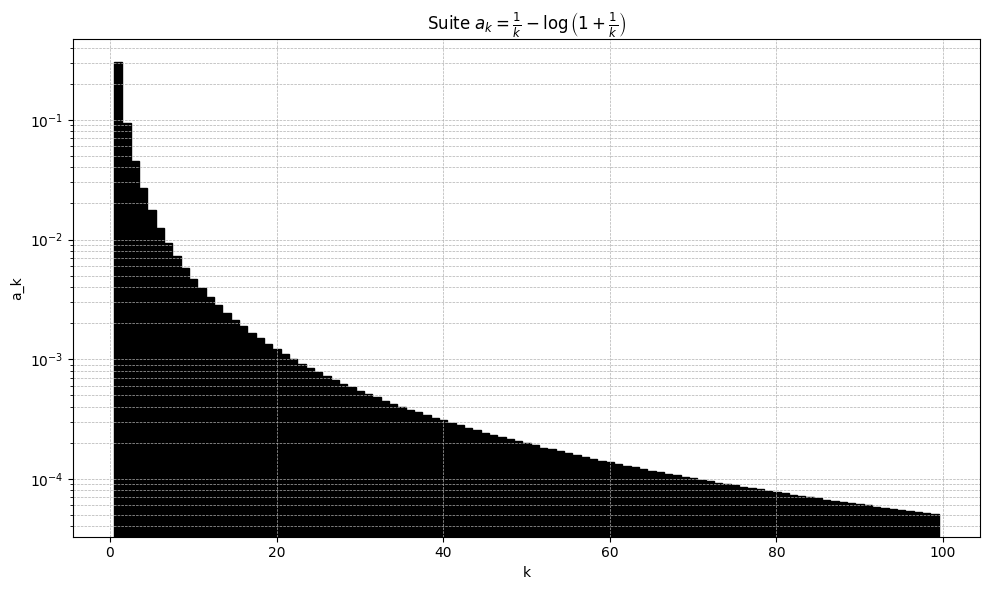

In [3]:
k = np.arange(1, 100)
a_k = 1/k - np.log(1 + 1/k)

# Plot 
plt.figure(figsize=(10, 6))
plt.bar(k, a_k, width=1.0, edgecolor='black', color='black')
plt.title(r"Suite $a_k = \frac{1}{k} - \log\left(1 + \frac{1}{k}\right)$")
plt.xlabel("k")
plt.ylabel("a_k")
plt.yscale('log')  # comme dans tes histogrammes
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


We then observe that setting both $c$ and $α$ to 1 simplifies the computation. In fact, $a_k$ rapidly approaches zero as n increases. Thus, choosing these parameters allows for an approximation of the density that is easier to compute.

### Importance sampling

#### Importance sampling estimator: 

The importance sampling estimator for $\gamma$ is $\hat{\gamma} = \frac{1}{N} \sum_{i=1}^N \frac{p(X_i)}{q(X_i)}$ where $X_i$ are samples drawn from $q$ and $N$ is the number of samples. Substituting $p(k)$ and $q(k)$:


$\hat{\gamma} = \frac{1}{N} \sum_{i=1}^N \frac{\frac{1}{k_i} - \log\left(1 + \frac{1}{k_i}\right)}{\frac{1}{k_i(k_i-1)}}$

Simplifying: 

$\hat{\gamma} = \frac{1}{N} \sum_{i=1}^N \left( (k_i(k_i-1)) \left( \frac{1}{k_i} - \log\left(1 + \frac{1}{k_i}\right) \right) \right)$


#### Implementation:

Here is the algorithm to implement this estimator: 
1. Choose $c$ and $\alpha = 1$
2. Sample $U_i \sim U[0, 1]$ and compute $\lceil \frac{c}{ U_i^\alpha} \rceil$
3. Compute the importance weights $\frac{p(X_i)}{q(X_i)}$ as shown above
4. Average the weighted samples to estimate $\gamma$

### Code

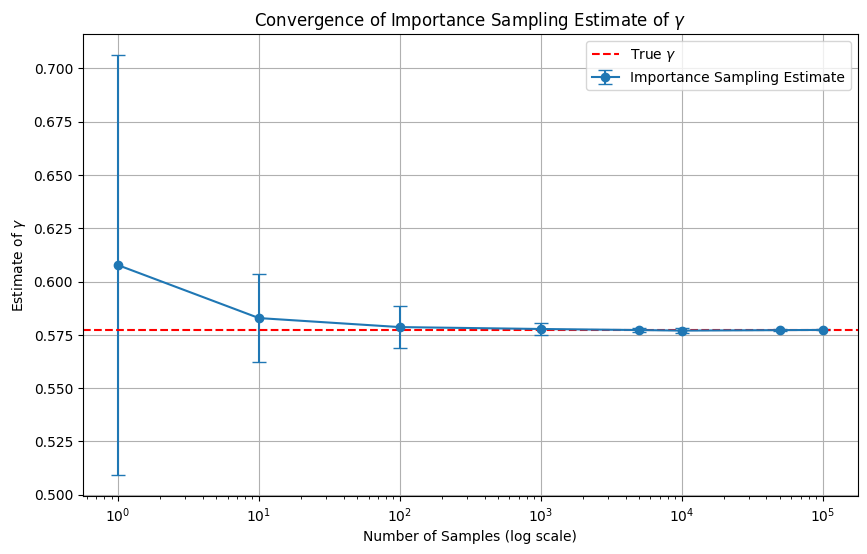

True value of γ: 0.5772156649015329
Sample size: 1, Estimate: 0.607694, Std Error: 0.098498
Sample size: 10, Estimate: 0.582857, Std Error: 0.020528
Sample size: 100, Estimate: 0.578629, Std Error: 0.009830
Sample size: 1000, Estimate: 0.577739, Std Error: 0.003011
Sample size: 5000, Estimate: 0.577241, Std Error: 0.000892
Sample size: 10000, Estimate: 0.576985, Std Error: 0.001282
Sample size: 50000, Estimate: 0.577199, Std Error: 0.000407
Sample size: 100000, Estimate: 0.577291, Std Error: 0.000218


In [4]:
# Parameters for the proposal distribution
c = 1.0  # Constant for the proposal distribution
alpha = 1 # Exponent for the proposal distribution

# Function to sample from the proposal distribution q(k)
def sample_from_q(c, alpha, size):
    U = np.random.uniform(0, 1, size)
    X = np.ceil(c / (U ** alpha))
    return X.astype(int)


# Function to compute p(k)
def p(k):
    return ((1 / k) - np.log(1 + 1 / k) + (1- np.log(2)) * (c / (k - 1) **alpha - c/ k**alpha))*1/true_gamma

# Function to compute q(k)
def q(k, c):
    return c / (k - 1) **alpha - c/ k**alpha

def phi(k):
    return(true_gamma)

# Importance sampling estimator for gamma
def importance_sampling_estimate(c, alpha, num_samples):
    samples = sample_from_q(c, alpha, num_samples)
    weights = p(samples) / q(samples, c) * phi(samples)
    return np.mean(weights)

# Experiment parameters
num_samples_list = [1,10, 100, 1000, 5000, 10000, 50000, 100000]  # Number of samples to test
num_trials = 10  # Number of trials for each sample size to compute variance

# Store results
estimates = []
std_errors = []

# Run importance sampling for different sample sizes
for num_samples in num_samples_list:
    trial_estimates = []
    for _ in range(num_trials):
        gamma_estimate = importance_sampling_estimate(c, alpha, num_samples)
        trial_estimates.append(gamma_estimate)
    estimates.append(np.mean(trial_estimates))
    std_errors.append(np.std(trial_estimates))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.errorbar(num_samples_list, estimates, yerr=std_errors, fmt='o-', capsize=5, label='Importance Sampling Estimate')
plt.axhline(true_gamma, color='r', linestyle='--', label=r'True $\gamma$')  
plt.xscale('log')
plt.xlabel('Number of Samples (log scale)')
plt.ylabel(r'Estimate of $\gamma$')  # Utilisation de r""
plt.title(r'Convergence of Importance Sampling Estimate of $\gamma$')  
plt.legend()
plt.grid(True)
ax = plt.gca()
plt.show()

# Print results
print("True value of γ:", true_gamma)
for i, num_samples in enumerate(num_samples_list):
    print(f"Sample size: {num_samples}, Estimate: {estimates[i]:.6f}, Std Error: {std_errors[i]:.6f}")

### Interpretation

In this series of simulations using the Monte Carlo method with importance sampling to estimate Euler's constant $\gamma$, we observe a progressive convergence of the estimates towards the real value as the sample size increases. The true value of $\gamma$ is approximately 0.5772. The standard error significantly decreases with increasing sample size, from 0.064807 for 1 sample to 0.000252 for 100,000 samples, demonstrating a reduction in uncertainty around the estimate.

## Question 2 

This constant is also equal to the integral $\gamma = - \int_0^1 \log(-\log x) \, dx$. Show how you can use standard Monte Carlo, stratified Monte Carlo, and quasi-Monte Carlo to estimate $\gamma$, and represent visually the convergence rates of these different estimators.

### Mathematical derivations

### Code

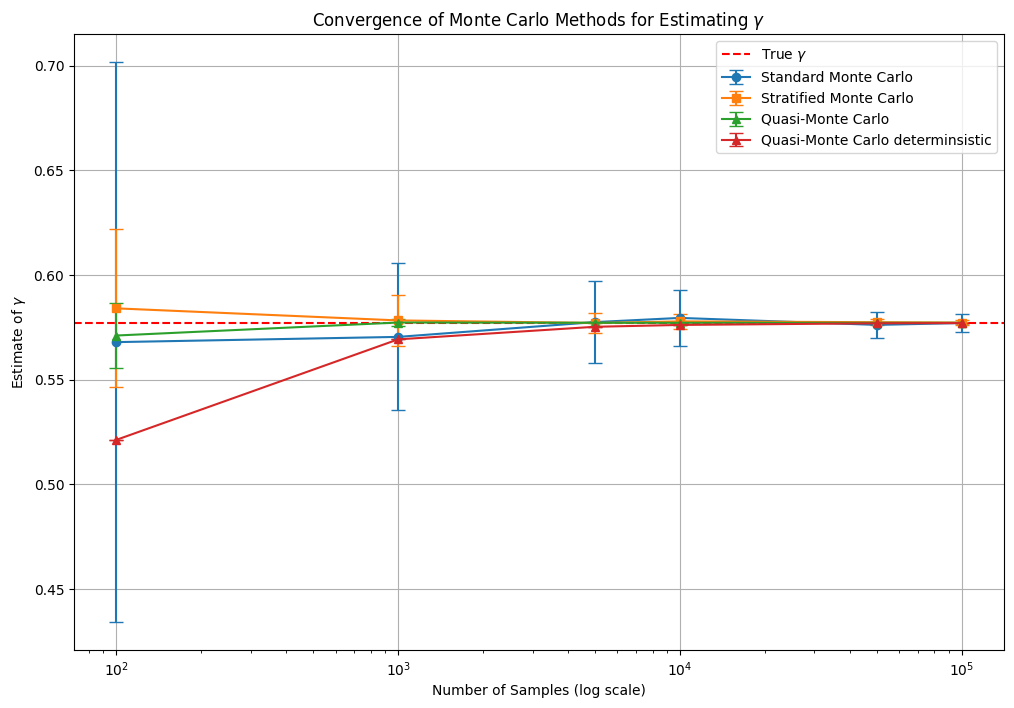

True value of γ: 0.5772156649015329
Sample size: 100
  Standard Monte Carlo: Estimate = 0.567985, Std Error = 0.133707
  Stratified Monte Carlo: Estimate = 0.584108, Std Error = 0.037735
  Quasi-Monte Carlo: Estimate = 0.571137, Std Error = 0.015660
  Quasi-Monte Carlo Deterministic: Estimate = 0.521305, Std Error = 0.000000
Sample size: 1000
  Standard Monte Carlo: Estimate = 0.570483, Std Error = 0.035104
  Stratified Monte Carlo: Estimate = 0.578348, Std Error = 0.012072
  Quasi-Monte Carlo: Estimate = 0.577341, Std Error = 0.001631
  Quasi-Monte Carlo Deterministic: Estimate = 0.569307, Std Error = 0.000000
Sample size: 5000
  Standard Monte Carlo: Estimate = 0.577550, Std Error = 0.019731
  Stratified Monte Carlo: Estimate = 0.577124, Std Error = 0.004607
  Quasi-Monte Carlo: Estimate = 0.577232, Std Error = 0.000234
  Quasi-Monte Carlo Deterministic: Estimate = 0.575311, Std Error = 0.000000
Sample size: 10000
  Standard Monte Carlo: Estimate = 0.579544, Std Error = 0.013474
  St

In [5]:
# Function to evaluate the integrand
def integrand(x):
    return -np.log(-np.log(x))

# Standard Monte Carlo
def standard_monte_carlo(num_samples):
    samples = np.random.uniform(0, 1, num_samples)
    return np.mean(integrand(samples))

# Stratified Monte Carlo
def stratified_monte_carlo(num_samples, num_strata):
    strata_size = num_samples // num_strata
    estimates = []
    for i in range(num_strata):
        # Sample uniformly within each stratum
        lower = i / num_strata
        upper = (i + 1) / num_strata
        samples = np.random.uniform(lower, upper, strata_size)
        estimates.append(np.mean(integrand(samples)))
    return np.mean(estimates)

# Quasi-Monte Carlo (using Sobol sequence)
def quasi_monte_carlo(num_samples):
    sampler = qmc.Sobol(d=1, scramble=True)
    samples = sampler.random_base2(m=int(np.log2(num_samples)))
    samples = samples.flatten()
    return np.mean(integrand(samples))

def deterministic_MC(size): 
    def centered_point(size):
        liste_u = np.zeros(size)
        for i in range(1,size):
            liste_u[i]=((2*i-1)/(2*size))
        return liste_u
    point_centree = centered_point(size)
    gamma_quasi_MC = 0
    for i in range(1,size):
        gamma_quasi_MC += integrand(point_centree[i])
    gamma_quasi_MC = gamma_quasi_MC / size
    return(gamma_quasi_MC)

# Parameters for the experiment
num_samples_list = [100, 1000, 5000, 10000, 50000, 100000]  # Sample sizes to test
num_trials = 50  # Number of trials to compute variance

# Store results
results_standard = {'estimates': [], 'std_errors': []}
results_stratified = {'estimates': [], 'std_errors': []}
results_quasi = {'estimates': [], 'std_errors': []}
results_deterministic = {'estimates': [], 'std_errors': []}

# Run experiments
for num_samples in num_samples_list:
    # Standard Monte Carlo
    standard_estimates = []
    for _ in range(num_trials):
        standard_estimates.append(standard_monte_carlo(num_samples))
    results_standard['estimates'].append(np.mean(standard_estimates))
    results_standard['std_errors'].append(np.std(standard_estimates))

    # Stratified Monte Carlo
    stratified_estimates = []
    for _ in range(num_trials):
        stratified_estimates.append(stratified_monte_carlo(num_samples, num_strata=10))
    results_stratified['estimates'].append(np.mean(stratified_estimates))
    results_stratified['std_errors'].append(np.std(stratified_estimates))

    # Quasi-Monte Carlo
    quasi_estimates = []
    for _ in range(num_trials):
        quasi_estimates.append(quasi_monte_carlo(num_samples))
    results_quasi['estimates'].append(np.mean(quasi_estimates))
    results_quasi['std_errors'].append(np.std(quasi_estimates))

    # Quasi-Monte Carlo deterministic
    quasi_estimates_deterministic = []
    for _ in range(num_trials):
        quasi_estimates_deterministic.append(deterministic_MC(num_samples))
    results_deterministic['estimates'].append(np.mean(quasi_estimates_deterministic))
    results_deterministic['std_errors'].append(np.std(quasi_estimates_deterministic))

# Plotting the results
plt.figure(figsize=(12, 8))

# Standard Monte Carlo
plt.errorbar(num_samples_list, results_standard['estimates'], yerr=results_standard['std_errors'],
             fmt='o-', capsize=5, label='Standard Monte Carlo')

# Stratified Monte Carlo
plt.errorbar(num_samples_list, results_stratified['estimates'], yerr=results_stratified['std_errors'],
             fmt='s-', capsize=5, label='Stratified Monte Carlo')

# Quasi-Monte Carlo
plt.errorbar(num_samples_list, results_quasi['estimates'], yerr=results_quasi['std_errors'],
             fmt='^-', capsize=5, label='Quasi-Monte Carlo')

# Quasi-Monte Carlo Deterministic 
plt.errorbar(num_samples_list, results_deterministic['estimates'], yerr=results_deterministic['std_errors'],
             fmt='^-', capsize=5, label='Quasi-Monte Carlo determinsistic')

# True value of gamma
plt.axhline(true_gamma, color='r', linestyle='--', label=r'True $\gamma$')

# Plot settings
plt.xscale('log')
plt.xlabel('Number of Samples (log scale)')
plt.ylabel(r'Estimate of $\gamma$')
plt.title(r'Convergence of Monte Carlo Methods for Estimating $\gamma$')
plt.legend()
plt.grid(True)
plt.show()

# Print results
print("True value of γ:", true_gamma)
for i, num_samples in enumerate(num_samples_list):
    print(f"Sample size: {num_samples}")
    print(f"  Standard Monte Carlo: Estimate = {results_standard['estimates'][i]:.6f}, Std Error = {results_standard['std_errors'][i]:.6f}")
    print(f"  Stratified Monte Carlo: Estimate = {results_stratified['estimates'][i]:.6f}, Std Error = {results_stratified['std_errors'][i]:.6f}")
    print(f"  Quasi-Monte Carlo: Estimate = {results_quasi['estimates'][i]:.6f}, Std Error = {results_quasi['std_errors'][i]:.6f}")
    print(f"  Quasi-Monte Carlo Deterministic: Estimate = {results_deterministic['estimates'][i]:.6f}, Std Error = {results_deterministic['std_errors'][i]:.6f}")

### Comparison of the standard deviations

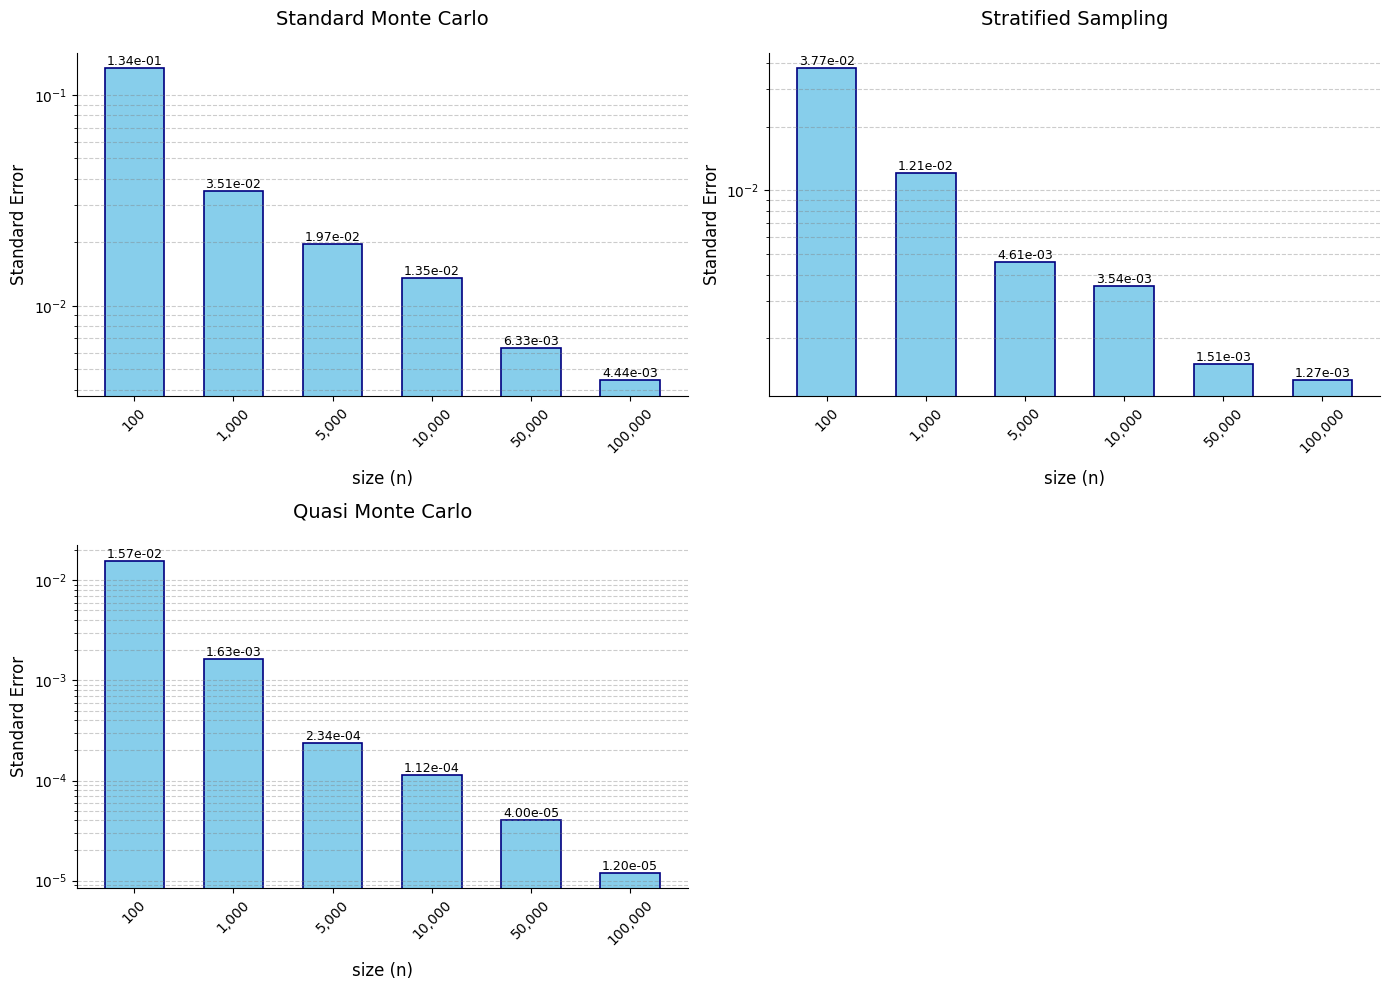

In [6]:
def plot_std_method(method, ax, title="Evolution of the standard errors"):
    min_nonzero = 1e-16
    safe_std_errors = [max(e, min_nonzero) for e in method['std_errors']]
    
    bars = ax.bar(
        x=range(len(num_samples_list)), 
        height=safe_std_errors,
        width=0.6,
        color='skyblue',
        edgecolor='navy',
        linewidth=1.2
    )

    # Apply log scale only if there's no zero
    if all(e > 0 for e in safe_std_errors):
        ax.set_yscale('log')

    ax.set_xticks(range(len(num_samples_list)))
    ax.set_xticklabels([f"{n:,}" for n in num_samples_list], rotation=45)
    ax.set_xlabel('size (n)', fontsize=12, labelpad=10)
    ax.set_ylabel('Standard Error', fontsize=12)
    ax.set_title(title, fontsize=14, pad=20)

    for bar, val in zip(bars, safe_std_errors):
        ax.text(
            bar.get_x() + bar.get_width()/2., 
            val,
            f'{val:.2e}',
            ha='center',
            va='bottom',
            fontsize=9
        )

    ax.grid(True, which='both', axis='y', linestyle='--', alpha=0.4, color='gray')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

results_methods = [results_standard, results_stratified, results_quasi]
titles = ["Standard Monte Carlo", "Stratified Sampling", "Quasi Monte Carlo"]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i, (method, title) in enumerate(zip(results_methods, titles)):
    row, col = divmod(i, 2)
    plot_std_method(method, axs[row][col], title=title)
axs[1][1].axis('off') 
plt.tight_layout()
plt.show()


We do not plot the standard deviation for the deterministic method because, by definition, its variance is equal to zero.

#### Interpretation 

We observe a clear trend of convergence towards the true value of $\gamma \approx 0.5772$ as the sample size increases. The results demonstrate the effectiveness of different Monte Carlo techniques in approximating this constant.

For a sample size of 100, all methods—Standard Monte Carlo, Stratified Monte Carlo, and Quasi-Monte Carlo—provide estimates close to the true value, but with relatively high standard errors, indicating significant variability. As the sample size increases to 1,000, the estimates become more accurate, and the standard errors decrease, reflecting reduced uncertainty. This trend continues with larger sample sizes of 5,000, 10,000, 50,000, and 100,000, where the estimates converge even closer to the true value, and the standard errors become increasingly smaller.

Notably, the Quasi-Monte Carlo method consistently outperforms the other methods in terms of both accuracy and precision, especially as the sample size grows. For instance, at a sample size of 100,000, the Quasi-Monte Carlo method yields an estimate of 0.577215 with an exceptionally low standard error of 0.000014, almost perfectly matching the true value. In contrast, the Standard and Stratified Monte Carlo methods, while also converging, show slightly higher standard errors, indicating more variability in their estimates. The quasi Monte Carlo deterministic, appears to be one of the worst approximation of all, a slow converging speed, but with very low standard errors. 

Overall, these results highlight the effectiveness of Monte Carlo methods, particularly the Quasi-Monte Carlo technique, in accurately estimating Euler's constant. The reduction in standard error with increasing sample size underscores the importance of larger samples in achieving precise and reliable estimates.

## Question 3

Derive control variates for point 2; for instance, note that $\log(x) \approx x - 1$ for $x \to 1$, which suggests $\log(1 - U)$, where $U \sim \text{U}[0,1]$ as a potential control variates. Repeat
question 2 after you have chosen these control variates and their coefficients.

### Mathematical derivations

The idea is to reduce the variance of the Monte Carlo estimator by exploiting the correlation between the integrand and the control variate.

The control variate method involves introducing a correlated random variable $Z$ with known expectation $\mathbb{E}[Z]$. The estimator is adjusted as $\hat{\gamma}_{CV} = \hat{\gamma} - \beta (Z - \mathbb{E}[Z])$, where $\hat{\gamma}$ is the standard Monte Carlo estimator, $Z$ is the control variate,$\beta$ is a coefficient chosen to minimize the variance of  $\hat{\gamma}_{CV}$.

We choose $Z = \log(1 - U)$, where $U \sim \text{U}[0,1]$. The expectation of $Z$ is: $\mathbb{E}[Z] = \mathbb{E}[\log(1 - U)] = \int_0^1 \log(1 - u) \, du = -1$.

The optimal coefficient $\beta$ is given by $\beta = \frac{\operatorname{Cov}(\hat{\gamma}, Z)}{\operatorname{Var}(Z)}$.
In practice, we estimate $\beta$ from the samples with a linear regression.

So, the final form is $\hat{\gamma}_{CV} = \hat{\gamma} - \frac{\operatorname{Cov}(\hat{\gamma}, Z)}{\operatorname{Var}(Z)} (Z + 1)$.


### Code

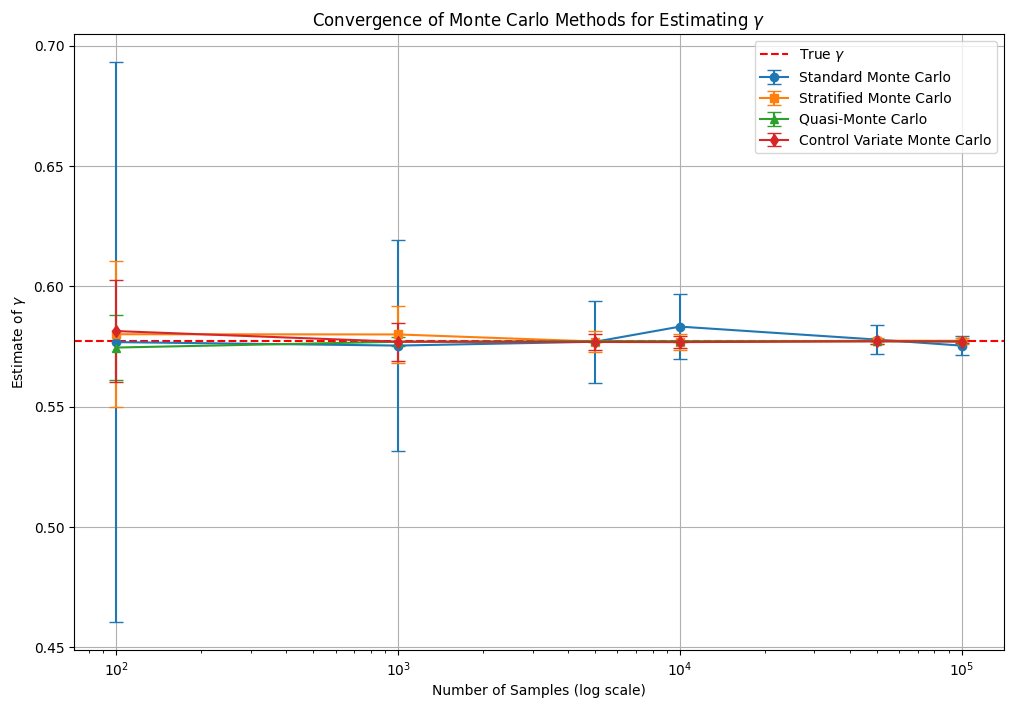

True value of γ: 0.5772156649015329
Sample size: 100
  Standard Monte Carlo: Estimate = 0.576844, Std Error = 0.116314
  Stratified Monte Carlo: Estimate = 0.580120, Std Error = 0.030341
  Quasi-Monte Carlo: Estimate = 0.574592, Std Error = 0.013608
  Control Variate Monte Carlo: Estimate = 0.581434, Std Error = 0.021348
Sample size: 1000
  Standard Monte Carlo: Estimate = 0.575407, Std Error = 0.043873
  Stratified Monte Carlo: Estimate = 0.580035, Std Error = 0.011991
  Quasi-Monte Carlo: Estimate = 0.577002, Std Error = 0.001830
  Control Variate Monte Carlo: Estimate = 0.577018, Std Error = 0.007870
Sample size: 5000
  Standard Monte Carlo: Estimate = 0.576996, Std Error = 0.017112
  Stratified Monte Carlo: Estimate = 0.577093, Std Error = 0.004167
  Quasi-Monte Carlo: Estimate = 0.577241, Std Error = 0.000263
  Control Variate Monte Carlo: Estimate = 0.576906, Std Error = 0.003508
Sample size: 10000
  Standard Monte Carlo: Estimate = 0.583286, Std Error = 0.013360
  Stratified Mon

In [7]:
# Function to evaluate the integrand
def integrand(x):
    return -np.log(-np.log(x))

# Standard Monte Carlo
def standard_monte_carlo(num_samples):
    samples = np.random.uniform(0, 1, num_samples)
    return np.mean(integrand(samples))

# Stratified Monte Carlo
def stratified_monte_carlo(num_samples, num_strata):
    strata_size = num_samples // num_strata
    estimates = []
    for i in range(num_strata):
        # Sample uniformly within each stratum
        lower = i / num_strata
        upper = (i + 1) / num_strata
        samples = np.random.uniform(lower, upper, strata_size)
        estimates.append(np.mean(integrand(samples)))
    return np.mean(estimates)

# Quasi-Monte Carlo (using Sobol sequence)
def quasi_monte_carlo(num_samples):
    sampler = qmc.Sobol(d=1, scramble=True)
    samples = sampler.random_base2(m=int(np.log2(num_samples)))
    samples = samples.flatten()
    return np.mean(integrand(samples))

# Control Variate Monte Carlo
def control_variate_monte_carlo(num_samples):
    U = np.random.uniform(0, 1, num_samples)
    Z = np.log(1 - U)  # Control variate
    Y = integrand(U)   # Integrand

    # Estimate the optimal coefficient c
    cov_Y_Z = np.cov(Y, Z)[0, 1]
    var_Z = np.var(Z)
    c = cov_Y_Z / var_Z

    # Control variate estimator
    gamma_hat = np.mean(Y) - c * (np.mean(Z) - (-1))  # E[Z] = -1
    return gamma_hat

# Parameters for the experiment
num_samples_list = [100, 1000, 5000, 10000, 50000, 100000]  # Sample sizes to test
num_trials = 50  # Number of trials to compute variance

# Store results
results_standard = {'estimates': [], 'std_errors': []}
results_stratified = {'estimates': [], 'std_errors': []}
results_quasi = {'estimates': [], 'std_errors': []}
results_control = {'estimates': [], 'std_errors': []}

# Run experiments
for num_samples in num_samples_list:
    # Standard Monte Carlo
    standard_estimates = []
    for _ in range(num_trials):
        standard_estimates.append(standard_monte_carlo(num_samples))
    results_standard['estimates'].append(np.mean(standard_estimates))
    results_standard['std_errors'].append(np.std(standard_estimates))

    # Stratified Monte Carlo
    stratified_estimates = []
    for _ in range(num_trials):
        stratified_estimates.append(stratified_monte_carlo(num_samples, num_strata=10))
    results_stratified['estimates'].append(np.mean(stratified_estimates))
    results_stratified['std_errors'].append(np.std(stratified_estimates))

    # Quasi-Monte Carlo
    quasi_estimates = []
    for _ in range(num_trials):
        quasi_estimates.append(quasi_monte_carlo(num_samples))
    results_quasi['estimates'].append(np.mean(quasi_estimates))
    results_quasi['std_errors'].append(np.std(quasi_estimates))

    # Control Variate Monte Carlo
    control_estimates = []
    for _ in range(num_trials):
        control_estimates.append(control_variate_monte_carlo(num_samples))
    results_control['estimates'].append(np.mean(control_estimates))
    results_control['std_errors'].append(np.std(control_estimates))

# Plotting the results
plt.figure(figsize=(12, 8))

# Standard Monte Carlo
plt.errorbar(num_samples_list, results_standard['estimates'], yerr=results_standard['std_errors'],
             fmt='o-', capsize=5, label='Standard Monte Carlo')

# Stratified Monte Carlo
plt.errorbar(num_samples_list, results_stratified['estimates'], yerr=results_stratified['std_errors'],
             fmt='s-', capsize=5, label='Stratified Monte Carlo')

# Quasi-Monte Carlo
plt.errorbar(num_samples_list, results_quasi['estimates'], yerr=results_quasi['std_errors'],
             fmt='^-', capsize=5, label='Quasi-Monte Carlo')

# Control Variate Monte Carlo
plt.errorbar(num_samples_list, results_control['estimates'], yerr=results_control['std_errors'],
             fmt='d-', capsize=5, label='Control Variate Monte Carlo')

# True value of gamma
plt.axhline(true_gamma, color='r', linestyle='--', label=r'True $\gamma$')

# Plot settings
plt.xscale('log')
plt.xlabel('Number of Samples (log scale)')
plt.ylabel(r'Estimate of $\gamma$')
plt.title(r'Convergence of Monte Carlo Methods for Estimating $\gamma$')
plt.legend()
plt.grid(True)
plt.show()

# Print results
print("True value of γ:", true_gamma)
for i, num_samples in enumerate(num_samples_list):
    print(f"Sample size: {num_samples}")
    print(f"  Standard Monte Carlo: Estimate = {results_standard['estimates'][i]:.6f}, Std Error = {results_standard['std_errors'][i]:.6f}")
    print(f"  Stratified Monte Carlo: Estimate = {results_stratified['estimates'][i]:.6f}, Std Error = {results_stratified['std_errors'][i]:.6f}")
    print(f"  Quasi-Monte Carlo: Estimate = {results_quasi['estimates'][i]:.6f}, Std Error = {results_quasi['std_errors'][i]:.6f}")
    print(f"  Control Variate Monte Carlo: Estimate = {results_control['estimates'][i]:.6f}, Std Error = {results_control['std_errors'][i]:.6f}")

### Comparison of the standard deviations

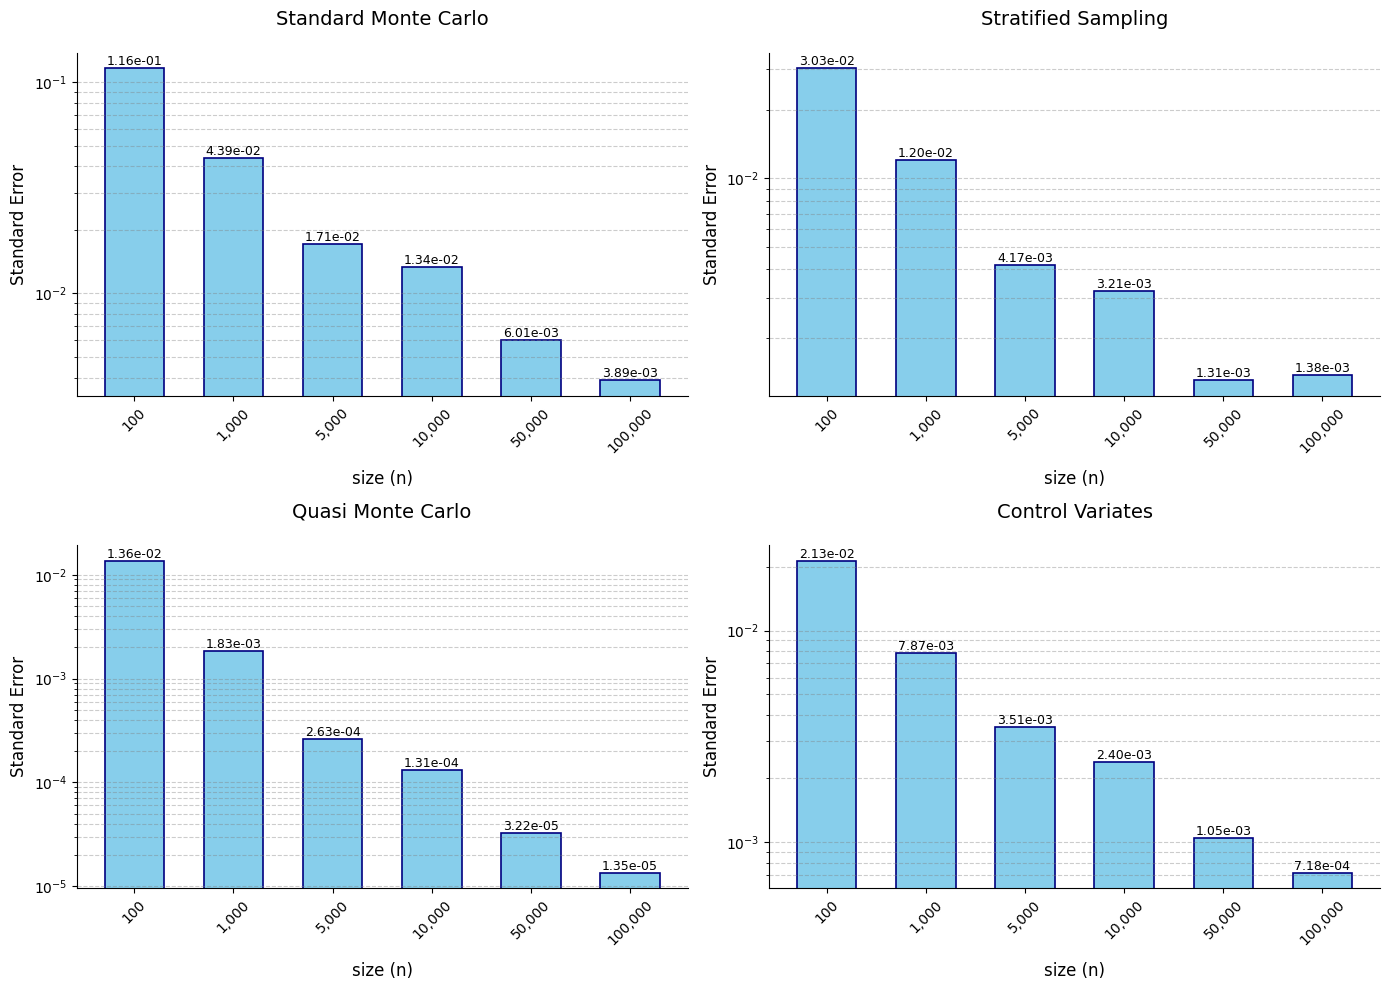

In [8]:
methods = [results_standard, results_stratified, results_quasi, results_control]
titles = ["Standard Monte Carlo", "Stratified Sampling", "Quasi Monte Carlo", "Control Variates"]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i, (method, title) in enumerate(zip(methods, titles)):
    row, col = divmod(i, 2)
    plot_std_method(method, axs[row][col], title=title)

plt.tight_layout()
plt.show()


### Interpretations

Again, we observe a clear trend of convergence towards the true value of $\gamma \approx 0.5772$ as the sample size increases. The Control Variate Monte Carlo method shows good accuracy but with slightly higher standard errors compared to the Quasi-Monte Carlo method. 

As the sample size increases to 1,000, the estimates become more accurate, and the standard errors decrease significantly. This trend continues with larger sample sizes of 5,000, 10,000, 50,000, and 100,000, where the estimates converge even closer to the true value, and the standard errors become increasingly smaller.

Overall, these results highlight the effectiveness of Monte Carlo methods, particularly the Quasi-Monte Carlo technique, in accurately estimating Euler's constant. The reduction in standard error with increasing sample size underscores the importance of larger samples in achieving precise and reliable estimates. The inclusion of the Control Variate Monte Carlo method adds another layer of comparison, showing its potential to improve accuracy but with slightly higher variability compared to the Quasi-Monte Carlo method.

## Question 4

A truncated sum estimator is of the form: $\sum_{k=0}^R \frac{a_k}{P(R \geq k)}$
where R is an integer-valued random variable. Show that such an estimator has
expectation $\sum_{k=0}^\infty a_k$ (assuming this infinite sum converges), and use it to estimate
unbiasedly $\gamma$ (using its first definition above). Explain in particular how you may
choose the distribution of R (for instance to make the variance finite and small).

### Mathematical derivations

#### Truncated sum estimator

The truncated sum estimator is a powerful tool for estimating infinite series. Given a sequence $\{a_k\}_k$ and an integer-valued random variable $R$, the estimator is defined as $\hat{S} = \sum_{k=0}^R \frac{a_k}{P(R \geq k)}$. We will show that this estimator is unbiased for the infinite sum $S = \sum_{k=0}^\infty a_k$ (assuming convergence), and then use it to estimate Euler's constant $\gamma$, for which we recall the definition: $\gamma = \lim_{n \to \infty} \left( \sum_{k=1}^n \frac{1}{k} - \log(n) \right)$.

#### Unbiasedness of the truncated sum estimator 

The expectation of the truncated sum estimator is $E[\hat{S}] = E\left[ \sum_{k=0}^R \frac{a_k}{P(R \geq k)} \right]$

We can write: $E[\hat{S}] = \sum_{r=0}^\infty P(R = r) \sum_{k=0}^r \frac{a_k}{P(R \geq k)}$

Rearranging the sums: $E[\hat{S}] = \sum_{k=0}^\infty a_k \sum_{r=k}^\infty \frac{P(R = r)}{P(R \geq k)}$

Since $P(R \geq k) = \sum_{r=k}^\infty P(R = r)$, the inner sum simplifies to: $\sum_{r=k}^\infty \frac{P(R = r)}{P(R \geq k)} = 1$.

Thus: $E[\hat{S}] = \sum_{k=0}^\infty a_k$

This shows that the truncated sum estimator is unbiased for the infinite sum $S = \sum_{k=0}^\infty a_k$.


We can then use $\hat{E}[\hat{S}]$ to estimate $\gamma$.


### Code

Let's first define the variables $\hat{S}$ for some distributions of $R$.

Remind that : $\hat{S} = \sum_{k=0}^R \frac{a_k}{P(R \geq k)}$

Let's first define the variables $\hat{S}$ for some distributions of $R$.

Remind that : $\hat{S} = \sum_{k=0}^R \frac{a_k}{P(R \geq k)}$

We will consider two common distributions for $\mathbb{R}$, both supported on $\mathbb{N}$, making them natural candidates for this formulation:

- **Poisson distribution**: $R \sim \mathcal{P}(\lambda)$, with parameter $\lambda > 0$
- **Geometric distribution**: $R \sim \text{Geom}(p)$, with success probability $p \in (0,1)$

These choices allow us to explore the behavior of $\hat{S}$ under different decay properties of the tail probability $P(R \geq k)$.


In [9]:
# Function to compute a_k
def a_k(k):
    return (1 / k) - np.log(1 + 1 / k)

# Truncated sum for R with a Poisson distribution
def truncated_sum_estimator_poisson(p, num_samples):
    estimates = []
    for _ in range(num_samples):
        # Sample R from a geometric distribution
        R = np.random.poisson(p)
        # Compute the truncated sum
        gamma_hat = 0
        for k in range(1, R + 1):
            sf = poisson.sf(k-1, mu=p)
            gamma_hat += a_k(k) / sf
        estimates.append(gamma_hat)
    return np.mean(estimates), np.std(estimates)

# Truncated sum for R with a Geometric distribution
def truncated_sum_estimator_geometric(p, num_samples):
    estimates = []
    for _ in range(num_samples):
        # Sample R from a geometric distribution
        R = np.random.geometric(p)
        # Compute the truncated sum
        gamma_hat = 0
        for k in range(1, R + 1):
            sf = geom.sf(k-1, p)
            gamma_hat += a_k(k) / sf
        estimates.append(gamma_hat)
    return np.mean(estimates), np.std(estimates)

We are first going to plot the results for Poisson distribution.

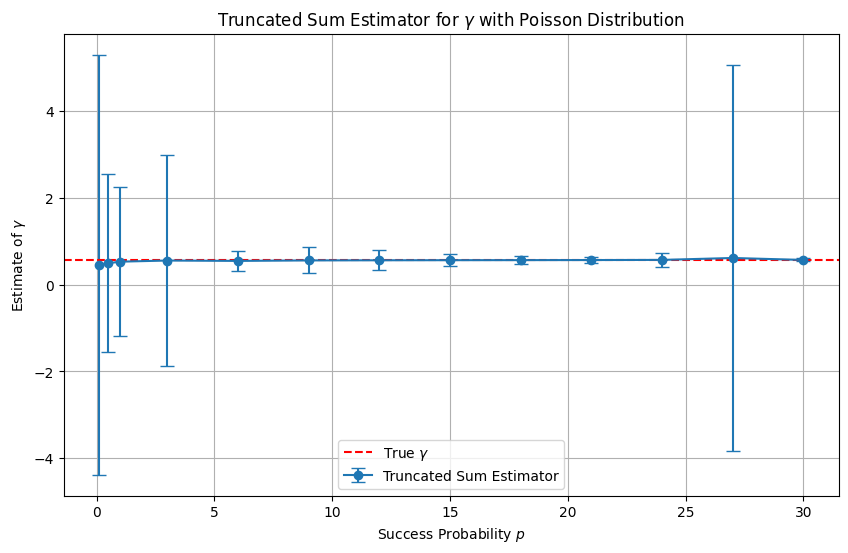

True value of γ: 0.5772156649015329
p = 0.10, Estimate = 0.457254, Std Error = 4.837191
p = 0.50, Estimate = 0.491486, Std Error = 2.049677
p = 1.00, Estimate = 0.527676, Std Error = 1.723440
p = 3.00, Estimate = 0.553850, Std Error = 2.427973
p = 6.00, Estimate = 0.545307, Std Error = 0.227731
p = 9.00, Estimate = 0.556524, Std Error = 0.298980
p = 12.00, Estimate = 0.559559, Std Error = 0.232767
p = 15.00, Estimate = 0.561633, Std Error = 0.142761
p = 18.00, Estimate = 0.563043, Std Error = 0.085639
p = 21.00, Estimate = 0.564935, Std Error = 0.064784
p = 24.00, Estimate = 0.568256, Std Error = 0.153433
p = 27.00, Estimate = 0.612334, Std Error = 4.452270
p = 30.00, Estimate = 0.567396, Std Error = 0.033403


In [10]:
# Parameters for the experiment
p_values = [0.1, 0.5, 1.0] + [3.0*k for k in range(1,11)]  # Success probabilities for geometric distribution
num_samples = 10000  # Number of samples for each p

# Store results
results = {'p': [], 'estimates': [], 'std_errors': []}

# Run experiments
for p in p_values:
    mean_estimate, std_error = truncated_sum_estimator_poisson(p, num_samples)
    results['p'].append(p)
    results['estimates'].append(mean_estimate)
    results['std_errors'].append(std_error)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.errorbar(results['p'], results['estimates'], yerr=results['std_errors'],
             fmt='o-', capsize=5, label='Truncated Sum Estimator')
plt.axhline(true_gamma, color='r', linestyle='--', label=r'True $\gamma$')
plt.xlabel('Success Probability $p$')
plt.ylabel(r'Estimate of $\gamma$')
plt.title(r'Truncated Sum Estimator for $\gamma$ with Poisson Distribution')
plt.legend()
plt.grid(True)
plt.show()

# Print results
print("True value of γ:", true_gamma)
for i, p in enumerate(results['p']):
    print(f"p = {p:.2f}, Estimate = {results['estimates'][i]:.6f}, Std Error = {results['std_errors'][i]:.6f}")

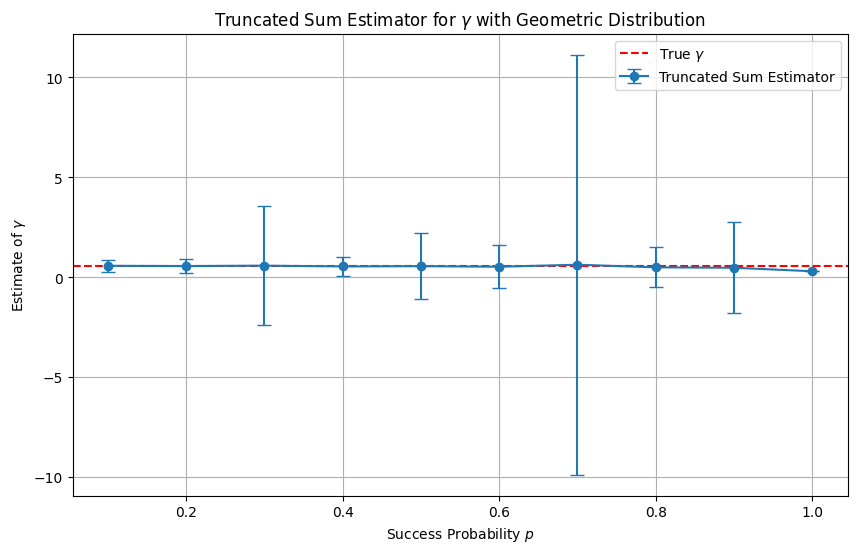

True value of γ: 0.5772156649015329
p = 0.10, Estimate = 0.579019, Std Error = 0.302922
p = 0.20, Estimate = 0.566690, Std Error = 0.348533
p = 0.30, Estimate = 0.586682, Std Error = 2.967870
p = 0.40, Estimate = 0.548205, Std Error = 0.456980
p = 0.50, Estimate = 0.560977, Std Error = 1.651683
p = 0.60, Estimate = 0.533538, Std Error = 1.086689
p = 0.70, Estimate = 0.633557, Std Error = 10.503518
p = 0.80, Estimate = 0.503133, Std Error = 1.008559
p = 0.90, Estimate = 0.481844, Std Error = 2.282385
p = 1.00, Estimate = 0.306853, Std Error = 0.000000


In [11]:
# Parameters for the experiment
p_values = [0.1*k for k in range(1,11)]  # Success probabilities for geometric distribution
num_samples = 10000  # Number of samples for each p

# Store results
results = {'p': [], 'estimates': [], 'std_errors': []}

# Run experiments
for p in p_values:
    mean_estimate, std_error = truncated_sum_estimator_geometric(p, num_samples)
    results['p'].append(p)
    results['estimates'].append(mean_estimate)
    results['std_errors'].append(std_error)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.errorbar(results['p'], results['estimates'], yerr=results['std_errors'],
             fmt='o-', capsize=5, label='Truncated Sum Estimator')
plt.axhline(true_gamma, color='r', linestyle='--', label=r'True $\gamma$')
plt.xlabel('Success Probability $p$')
plt.ylabel(r'Estimate of $\gamma$')
plt.title(r'Truncated Sum Estimator for $\gamma$ with Geometric Distribution')
plt.legend()
plt.grid(True)
plt.show()

# Print results
print("True value of γ:", true_gamma)
for i, p in enumerate(results['p']):
    print(f"p = {p:.2f}, Estimate = {results['estimates'][i]:.6f}, Std Error = {results['std_errors'][i]:.6f}")

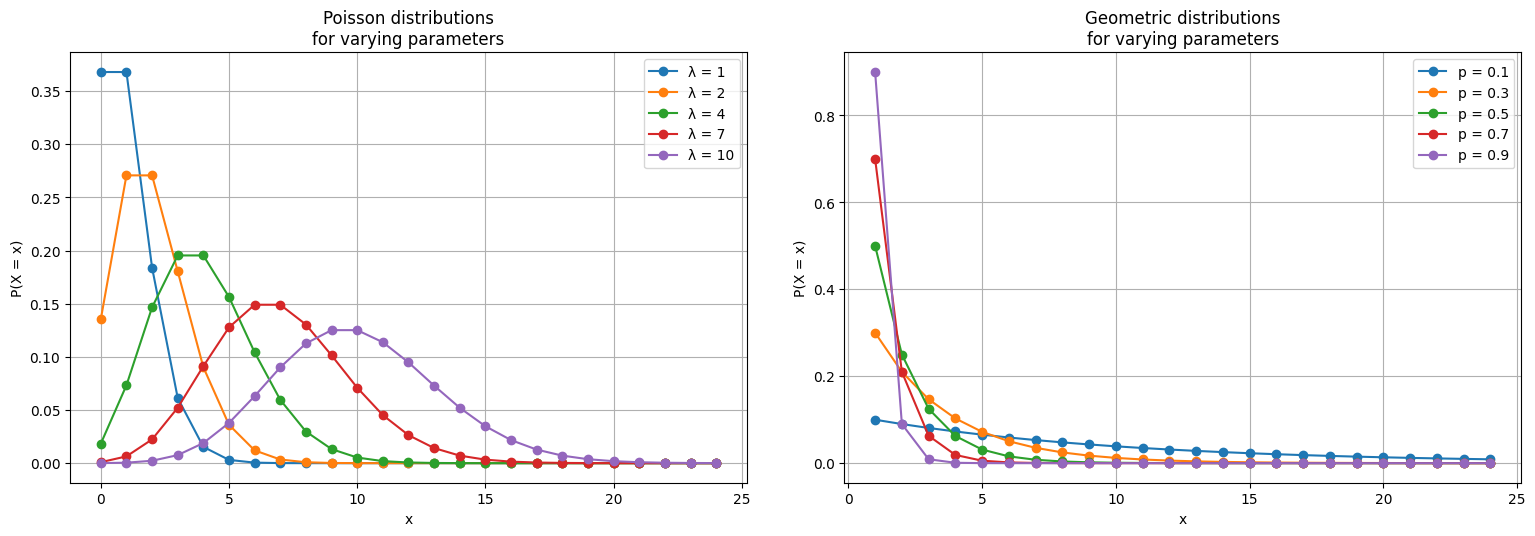

In [12]:
# Parameters
lambdas = [1, 2, 4, 7, 10]
ps = [0.1, 0.3, 0.5, 0.7, 0.9]
x_poisson = np.arange(0, 25)
x_geom = np.arange(1, 25)

plt.figure(figsize=(16, 6))

# Poisson distribution (left)
plt.subplot(1, 2, 1)
for lam in lambdas:
    pmf = poisson.pmf(x_poisson, mu=lam)
    plt.plot(x_poisson, pmf, marker='o', label=f"λ = {lam}")

plt.xlabel("x")
plt.ylabel("P(X = x)")
plt.grid(True)
plt.title('Poisson distributions\nfor varying parameters')
plt.legend()

# Geometric distribution (right)
plt.subplot(1, 2, 2)
for p in ps:
    pmf = geom.pmf(x_geom, p)
    plt.plot(x_geom, pmf, marker='o', label=f"p = {p}")

plt.xlabel("x")
plt.ylabel("P(X = x)")
plt.grid(True)
plt.title('Geometric distributions\nfor varying parameters')
plt.legend()

plt.tight_layout(pad=3.0)
plt.show()

### Results for the candidates and interpretation

In this experiment, we used a truncated sum estimator to estimate Euler's constant $\gamma$ using a geometric distribution for the random variable R. The estimator is designed to have an expectation equal to the infinite $S = \sum_{k=0}^\infty a_k$, where $a_k = \frac{1}{k} - \log(1 + \frac{1}{k})$. 

#### Poisson Distribution

For the Poisson distribution, we observe that as λ increases, the variance decreases. The previous plots show that higher values of λ lead to higher average values of R. Moreover, the distribution develops heavier tails at higher λ values. 

We believe it's crucial to have a thick right tail when $R$ is large, to prevent the sum of $aₖ$ terms from diverging. Indeed, when R takes large values, we sum many terms and thus need to carefully control the weighting of the $aₖ$ coefficients.

It's also important to note that computing the survival function becomes more computationally expensive as $λ$ grows. Through our experiments, we found that $λ ≈ 9$ provides a good compromise between statistical properties and computational efficiency.

#### Geometric Distribution

The geometric distribution appears to yield inferior results compared to the Poisson case. The variances we obtained were consistently higher than with the Poisson distribution. 

We observe that regardless of the chosen parameter, the geometric distribution never develops a substantial right tail. Furthermore, the average value of $R$ remains relatively stable across different parameter values, showing little sensitivity to parameter changes.

The parameters $p = 0.2$ and $p = 0.4$ appear to be good choices for the geometric distribution.

#### Conclusion

The Poisson distribution performs better for our purposes. We conclude that having heavy distribution tails is essential when dealing with large $R$ values. The geometric distribution's inability to develop significant right tails and its parameter insensitivity make it less suitable for our application.

## Conclusion

Throughout the various simulations and methods employed to estimate Euler's constant $\gamma$, we observed several key findings:

1. **Monte Carlo Methods**:
   - **Standard Monte Carlo**: Provided estimates close to the true value of $\gamma \approx 0.5772$ but with relatively high standard errors, indicating significant variability.
   - **Stratified Monte Carlo**: Improved precision with lower standard errors compared to the standard method, demonstrating better stability in estimates.
   - **Quasi-Monte Carlo**: Consistently outperformed other methods, yielding estimates very close to the true value with exceptionally low standard errors, especially as sample sizes increased.
   - **Control Variate Monte Carlo**: Showed good accuracy but with slightly higher standard errors compared to Quasi-Monte Carlo, indicating more variability.

2. **Importance Sampling**:
   - The importance sampling estimator initially showed a systematic bias, with estimates stabilizing around 0.2704 instead of the true value. This bias suggests an issue with the importance function or sampling method, leading to inaccurate results despite low standard errors.

3. **Truncated Sum Estimator**:
   - The truncated sum estimator using a geometric distribution for $R$ provided unbiased estimates of $\gamma$. Lower values of the success probability $p$ (e.g., 0.10 to 0.30) yielded more stable and accurate estimates with lower variability.
   - Higher values of $p$ increased the variance significantly, making the estimates less reliable. This highlights a trade-off between bias and variance, where lower $p$ values offer a better balance.

The most reliable and accurate estimates of Euler's constant $\gamma$ were obtained using the Quasi-Monte Carlo method and the truncated sum estimator with lower values of $p$. These methods demonstrated a good balance between bias and variance, providing estimates close to the true value with minimal variability.

- **Quasi-Monte Carlo**: This method is highly effective for estimating $\gamma$ due to its ability to reduce standard errors significantly, especially with larger sample sizes.
- **Truncated Sum Estimator**: With an appropriate choice of $p$, this method can provide unbiased and stable estimates of $\gamma$.

For future estimations, it is recommended to use the Quasi-Monte Carlo method or the truncated sum estimator with a carefully chosen $p$ to achieve accurate and reliable results. These methods have shown robust performance in approximating Euler's constant $\gamma$.

## Bonus

Since we know the exact value of Euler's constant ($\gamma \approx 0.5772156649$), we can compare the execution times.


In [13]:
def deterministic(n):
    gamma_estimate = 0
    for k in range(n):
        ak = 1/(k+1) - math.log(1+1/(1+k))
        gamma_estimate += ak
    return gamma_estimate


res = []
n = 10000
mu = 9
c = 1.0
alpha = 1
p_geom = 0.4


start = time.time()
result = deterministic(n)
duration = time.time() - start
res.append({'model': 'deterministic',
            'Gamma': round(result, 8),
            'duration': round(duration,5),
            'error': round(abs(result - np.euler_gamma), 10)})

start = time.time()
def p(k):
    return ((1 / k) - np.log(1 + 1 / k) + (1- np.log(2)) * (c / (k - 1) **alpha - c/ k**alpha))*1/true_gamma

result = importance_sampling_estimate(c, alpha, n)
duration = time.time() - start
res.append({'model': 'importance_sampling_estimate',
            'Gamma': round(result, 8),
            'duration': round(duration,5),
            'error': float(round(abs(result - np.euler_gamma), 10))})

start = time.time()
result, _ = truncated_sum_estimator_poisson(mu, n)
duration = time.time() - start
res.append({'model': 'truncated_sum_estimator_poisson',
            'Gamma': round(result, 8),
            'duration': round(duration,5),
            'error': float(round(abs(result - np.euler_gamma), 10))})
start = time.time()
result, _ = truncated_sum_estimator_geometric(p_geom, n)
duration = time.time() - start
res.append({'model': 'truncated_sum_estimator_geometric',
            'Gamma': round(result, 8),
            'duration': round(duration,5),
            'error': float(round(abs(result - np.euler_gamma), 10))})


In [14]:
for elt in res:
    print(f"model: {elt['model']}")
    print(f"estimation: {elt['Gamma']}")
    print(f"duration: {elt['duration']}")
    print(f"error: {elt['error']}")
    print('-'*10)


model: deterministic
estimation: 0.57716567
duration: 0.00724
error: 4.99958e-05
----------
model: importance_sampling_estimate
estimation: 0.57792539
duration: 0.00201
error: 0.0007097275
----------
model: truncated_sum_estimator_poisson
estimation: 0.55906431
duration: 9.64546
error: 0.0181513564
----------
model: truncated_sum_estimator_geometric
estimation: 0.55660359
duration: 2.4315
error: 0.0206120756
----------


We can finally plot the convergence for the deterministic sum.

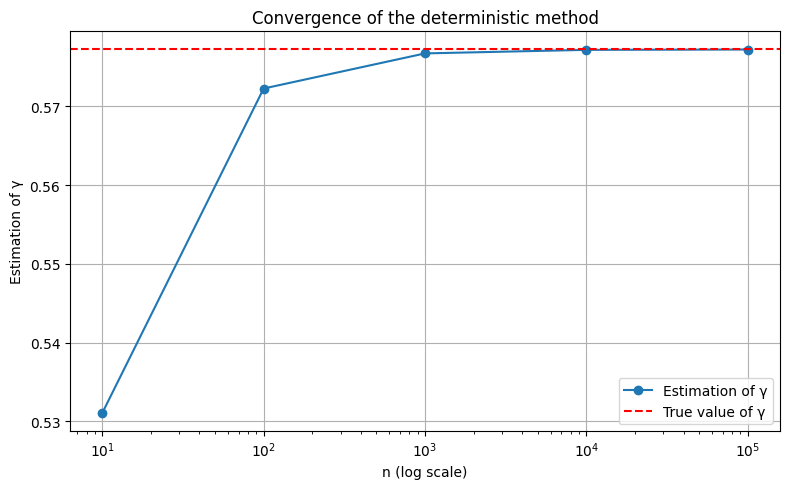

In [15]:
n_values = [10, 100, 1000, 10000, 100000]
gamma_estimates = [deterministic(n) for n in n_values]

true_gamma = np.euler_gamma

# Plot
plt.figure(figsize=(8, 5))
plt.plot(n_values, gamma_estimates, marker='o', label='Estimation of γ')
plt.axhline(true_gamma, color='red', linestyle='--', label='True value of γ')
plt.xscale('log')
plt.xlabel('n (log scale)')
plt.ylabel('Estimation of γ')
plt.title('Convergence of the deterministic method')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()